In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms, datasets
from CNNClassifier import CNNClassifier
from tqdm import tqdm
import os
import pickle
import matplotlib.pyplot as plt

f:\Uni\Cuda-Lab\Cuda_Lab\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BSZ = 128

In [3]:
def train(model, dataloader, optimizer, lossfunction):
    model.train()
    loss_sum = 0
        
    for batch, (x, labels) in enumerate(tqdm(dataloader)):

        x = x.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(x)
        loss = lossfunction(predictions,labels.to(torch.long))

        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
                    
    return loss_sum/len(dataloader)

def test(model,dataloader,lossfunction):
    model.eval()
    correct = 0
    loss_sum = 0
    predictions_tensor = torch.Tensor([]).to(device)
    ground_truth_tensor = torch.Tensor([]).to(device)

    with torch.no_grad():
        for i, (x, labels) in enumerate(tqdm(dataloader)):

            x = x.to(device)
            labels = labels.to(device)
            predictions = model(x)
            loss = lossfunction(predictions,labels.to(torch.long))
            loss_sum += loss.item()
            _, predicted_labels = torch.max(predictions, 1)
            predictions_tensor = torch.cat((predictions_tensor, predicted_labels))
            ground_truth_tensor = torch.cat((ground_truth_tensor, labels))
            #print(predicted_labels)
            correct += torch.sum(predicted_labels == labels).item()
        

    return correct, loss_sum/len(dataloader), predictions_tensor, ground_truth_tensor



In [4]:
data_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

SVHN_dataset = torchvision.datasets.SVHN(root='./data', download=True, transform=data_transform)

SVHN_trainset, SVHN_validationset = torch.utils.data.random_split(SVHN_dataset, [len(SVHN_dataset) - 10000, 10000])  

SVHN_trainloader = torch.utils.data.DataLoader(SVHN_trainset, batch_size=BSZ,
                                          shuffle=True, num_workers=2)

SVHN_validationloader = torch.utils.data.DataLoader(SVHN_validationset, batch_size=BSZ,
                                          shuffle=True, num_workers=2)

SVHN_testset = torchvision.datasets.SVHN(root='./data', split="test", download=True, transform=data_transform, )
SVHN_testloader = torch.utils.data.DataLoader(SVHN_testset, batch_size=BSZ,
                                         shuffle=False, num_workers=2)

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


In [5]:
model1 = CNNClassifier(ds_method="Maxpooling").to(device)
model2 = CNNClassifier(ds_method="Averagepooling").to(device)
model3 = CNNClassifier(ds_method="Stridedconv").to(device)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [6]:
def training(model, optimizer, trainloader, validationloader, epochs, save=True):
    print("Model: ", model)
    train_loss_list = []
    train_accuracy_list = []
    validation_loss_list = []
    validation_accuracy_list = []

    for epoch in range(epochs):
        train_loss = train(model, trainloader , optimizer, loss_fn)
        train_accuracy, _, _, _ = test(model, trainloader, loss_fn) 
        train_accuracy = train_accuracy / len(trainloader) / BSZ
        validation_accuracy, validation_loss, _, _ = test(model, validationloader, loss_fn) 
        validation_accuracy = validation_accuracy / len(validationloader) / BSZ
        print("Epoch", epoch + 1)
        print("Epoch Train Loss: {}, Epoch Train Accuracy: {}".format(train_loss, train_accuracy))
        print("Epoch Validation Loss: {}, Epoch Validation Accuracy: {} \n".format(validation_loss, validation_accuracy))
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        validation_loss_list.append(validation_loss)
        validation_accuracy_list.append(validation_accuracy)
        #num_gradient_list.append(num_gradient.item())
        
                
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    if(not os.path.exists("traingtracks")):
        os.makedirs("traingtracks")
    
    if save:
        savepath = f"models/model_{model.ds_method}.pth"
        
        torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, savepath)
    
    return train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list

In [7]:
%%time
tl_max, ta_max, vl_max, va_max = training(model1, optimizer1, SVHN_trainloader, SVHN_validationloader, 20)

Model:  CNNClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ds_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplac

100%|██████████| 79/79 [00:05<00:00, 15.61it/s]


Epoch 1
Epoch Train Loss: 2.0968945149219396, Epoch Train Accuracy: 0.5978693181818182
Epoch Validation Loss: 1.4831530927102776, Epoch Validation Accuracy: 0.5972112341772152 



100%|██████████| 79/79 [00:05<00:00, 15.32it/s]


Epoch 2
Epoch Train Loss: 1.7024465209305888, Epoch Train Accuracy: 0.7898042929292929
Epoch Validation Loss: 1.0493723455863664, Epoch Validation Accuracy: 0.7712618670886076 



100%|██████████| 79/79 [00:09<00:00,  8.72it/s]


Epoch 3
Epoch Train Loss: 1.572852777712273, Epoch Train Accuracy: 0.814330808080808
Epoch Validation Loss: 0.8441027674493911, Epoch Validation Accuracy: 0.7888647151898734 



100%|██████████| 79/79 [00:05<00:00, 13.30it/s]


Epoch 4
Epoch Train Loss: 1.5250060852127847, Epoch Train Accuracy: 0.8366477272727273
Epoch Validation Loss: 0.9391144325461569, Epoch Validation Accuracy: 0.8106210443037974 



100%|██████████| 79/79 [00:05<00:00, 14.02it/s]


Epoch 5
Epoch Train Loss: 1.4886417911510275, Epoch Train Accuracy: 0.8922348484848485
Epoch Validation Loss: 0.694170812640009, Epoch Validation Accuracy: 0.8631329113924051 



100%|██████████| 79/79 [00:06<00:00, 12.58it/s]


Epoch 6
Epoch Train Loss: 1.4326468462895865, Epoch Train Accuracy: 0.8991635101010101
Epoch Validation Loss: 0.6736917325967475, Epoch Validation Accuracy: 0.8673852848101266 



100%|██████████| 79/79 [00:06<00:00, 12.57it/s]


Epoch 7
Epoch Train Loss: 1.4101594633526273, Epoch Train Accuracy: 0.9039772727272727
Epoch Validation Loss: 0.6634039097948919, Epoch Validation Accuracy: 0.8716376582278481 



100%|██████████| 79/79 [00:06<00:00, 11.87it/s]


Epoch 8
Epoch Train Loss: 1.3997440227354416, Epoch Train Accuracy: 0.9110953282828282
Epoch Validation Loss: 0.6405040697206424, Epoch Validation Accuracy: 0.8734177215189873 



100%|██████████| 79/79 [00:06<00:00, 12.28it/s]


Epoch 9
Epoch Train Loss: 1.3780902826424801, Epoch Train Accuracy: 0.9289772727272727
Epoch Validation Loss: 0.5672023926354661, Epoch Validation Accuracy: 0.8879549050632911 



100%|██████████| 79/79 [00:06<00:00, 12.01it/s]


Epoch 10
Epoch Train Loss: 1.374980757453225, Epoch Train Accuracy: 0.9289614898989899
Epoch Validation Loss: 0.5560208270444146, Epoch Validation Accuracy: 0.8880537974683544 



100%|██████████| 79/79 [00:06<00:00, 12.28it/s]


Epoch 11
Epoch Train Loss: 1.3616032459519125, Epoch Train Accuracy: 0.9368371212121213
Epoch Validation Loss: 0.5680091988436783, Epoch Validation Accuracy: 0.8930973101265823 



100%|██████████| 79/79 [00:06<00:00, 12.29it/s]


Epoch 12
Epoch Train Loss: 1.3576557937294547, Epoch Train Accuracy: 0.940530303030303
Epoch Validation Loss: 0.5765253256393384, Epoch Validation Accuracy: 0.8903283227848101 



100%|██████████| 79/79 [00:06<00:00, 12.98it/s]


Epoch 13
Epoch Train Loss: 1.3443827863895532, Epoch Train Accuracy: 0.9417455808080808
Epoch Validation Loss: 0.5682229690159424, Epoch Validation Accuracy: 0.8950751582278481 



100%|██████████| 79/79 [00:06<00:00, 12.54it/s]


Epoch 14
Epoch Train Loss: 1.3414567957020769, Epoch Train Accuracy: 0.9467013888888889
Epoch Validation Loss: 0.5440312442900259, Epoch Validation Accuracy: 0.8965585443037974 



100%|██████████| 79/79 [00:06<00:00, 12.39it/s]


Epoch 15
Epoch Train Loss: 1.3471348485561332, Epoch Train Accuracy: 0.9453282828282829
Epoch Validation Loss: 0.5722067872934704, Epoch Validation Accuracy: 0.8904272151898734 



100%|██████████| 79/79 [00:06<00:00, 12.29it/s]


Epoch 16
Epoch Train Loss: 1.336930296878622, Epoch Train Accuracy: 0.9474431818181818
Epoch Validation Loss: 0.5534014384957808, Epoch Validation Accuracy: 0.8928995253164557 



100%|██████████| 79/79 [00:06<00:00, 12.36it/s]


Epoch 17
Epoch Train Loss: 1.3304601522407147, Epoch Train Accuracy: 0.9505366161616161
Epoch Validation Loss: 0.5368067761765251, Epoch Validation Accuracy: 0.8943829113924051 



100%|██████████| 79/79 [00:06<00:00, 13.00it/s]


Epoch 18
Epoch Train Loss: 1.3192861241523666, Epoch Train Accuracy: 0.955508207070707
Epoch Validation Loss: 0.534342179570017, Epoch Validation Accuracy: 0.8983386075949367 



100%|██████████| 79/79 [00:06<00:00, 12.60it/s]


Epoch 19
Epoch Train Loss: 1.3226698466021605, Epoch Train Accuracy: 0.9571022727272728
Epoch Validation Loss: 0.5177860674978811, Epoch Validation Accuracy: 0.8998219936708861 



100%|██████████| 79/79 [00:06<00:00, 12.71it/s]

Epoch 20
Epoch Train Loss: 1.3200095760701882, Epoch Train Accuracy: 0.9557765151515152
Epoch Validation Loss: 0.5270291265053085, Epoch Validation Accuracy: 0.8972507911392406 

CPU times: total: 11min 11s
Wall time: 12min 38s


In [8]:
%%time
tl_avg, ta_avg, vl_avg, va_avg = training(model2, optimizer2, SVHN_trainloader, SVHN_validationloader, 20)

Model:  CNNClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ds_layer): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Conv2d(256, 512

100%|██████████| 79/79 [00:06<00:00, 12.62it/s]


Epoch 1
Epoch Train Loss: 2.2916528215311995, Epoch Train Accuracy: 0.18899936868686867
Epoch Validation Loss: 2.266090857831738, Epoch Validation Accuracy: 0.18651107594936708 



100%|██████████| 79/79 [00:06<00:00, 12.55it/s]


Epoch 2
Epoch Train Loss: 2.1682734790474476, Epoch Train Accuracy: 0.4280618686868687
Epoch Validation Loss: 1.7843742325336118, Epoch Validation Accuracy: 0.43374208860759494 



100%|██████████| 79/79 [00:06<00:00, 12.57it/s]


Epoch 3
Epoch Train Loss: 1.9629943418984461, Epoch Train Accuracy: 0.5169349747474747
Epoch Validation Loss: 1.656188948244988, Epoch Validation Accuracy: 0.5134493670886076 



100%|██████████| 79/79 [00:06<00:00, 12.54it/s]


Epoch 4
Epoch Train Loss: 1.7949404964543352, Epoch Train Accuracy: 0.7556502525252525
Epoch Validation Loss: 1.1598347689532027, Epoch Validation Accuracy: 0.7369462025316456 



100%|██████████| 79/79 [00:05<00:00, 13.50it/s]


Epoch 5
Epoch Train Loss: 1.6054733692997634, Epoch Train Accuracy: 0.8084753787878788
Epoch Validation Loss: 0.8925889013688776, Epoch Validation Accuracy: 0.787381329113924 



100%|██████████| 79/79 [00:06<00:00, 12.29it/s]


Epoch 6
Epoch Train Loss: 1.5486708645868783, Epoch Train Accuracy: 0.818292297979798
Epoch Validation Loss: 0.8663937675802014, Epoch Validation Accuracy: 0.8025118670886076 



100%|██████████| 79/79 [00:06<00:00, 12.92it/s]


Epoch 7
Epoch Train Loss: 1.5160300144041428, Epoch Train Accuracy: 0.8296875
Epoch Validation Loss: 0.8287710879422441, Epoch Validation Accuracy: 0.8065664556962026 



100%|██████████| 79/79 [00:06<00:00, 12.73it/s]


Epoch 8
Epoch Train Loss: 1.4896667687579839, Epoch Train Accuracy: 0.8357323232323233
Epoch Validation Loss: 0.7783439529093006, Epoch Validation Accuracy: 0.8139833860759493 



100%|██████████| 79/79 [00:05<00:00, 13.95it/s]


Epoch 9
Epoch Train Loss: 1.4702313066733004, Epoch Train Accuracy: 0.8461174242424242
Epoch Validation Loss: 0.7352189006684702, Epoch Validation Accuracy: 0.819620253164557 



100%|██████████| 79/79 [00:05<00:00, 14.18it/s]


Epoch 10
Epoch Train Loss: 1.4471522957387597, Epoch Train Accuracy: 0.8481534090909091
Epoch Validation Loss: 0.6958097932459433, Epoch Validation Accuracy: 0.8221914556962026 



100%|██████████| 79/79 [00:06<00:00, 13.08it/s]


Epoch 11
Epoch Train Loss: 1.4357405414484967, Epoch Train Accuracy: 0.8516887626262626
Epoch Validation Loss: 0.675009347592728, Epoch Validation Accuracy: 0.8225870253164557 



100%|██████████| 79/79 [00:06<00:00, 12.84it/s]


Epoch 12
Epoch Train Loss: 1.4283609057917739, Epoch Train Accuracy: 0.8565972222222222
Epoch Validation Loss: 0.665637008751495, Epoch Validation Accuracy: 0.825059335443038 



100%|██████████| 79/79 [00:05<00:00, 13.91it/s]


Epoch 13
Epoch Train Loss: 1.4156914804921006, Epoch Train Accuracy: 0.8489425505050505
Epoch Validation Loss: 0.6676293988771076, Epoch Validation Accuracy: 0.8190268987341772 



100%|██████████| 79/79 [00:06<00:00, 12.77it/s]


Epoch 14
Epoch Train Loss: 1.4120669661146221, Epoch Train Accuracy: 0.8636363636363636
Epoch Validation Loss: 0.6567201252225079, Epoch Validation Accuracy: 0.8289161392405063 



100%|██████████| 79/79 [00:06<00:00, 12.83it/s]


Epoch 15
Epoch Train Loss: 1.3962799769459349, Epoch Train Accuracy: 0.8653409090909091
Epoch Validation Loss: 0.6563030768044388, Epoch Validation Accuracy: 0.8303995253164557 



100%|██████████| 79/79 [00:05<00:00, 14.11it/s]


Epoch 16
Epoch Train Loss: 1.3873184977155744, Epoch Train Accuracy: 0.8680871212121212
Epoch Validation Loss: 0.6244869375530677, Epoch Validation Accuracy: 0.8305973101265823 



100%|██████████| 79/79 [00:05<00:00, 13.83it/s]


Epoch 17
Epoch Train Loss: 1.3765632269358394, Epoch Train Accuracy: 0.8720012626262627
Epoch Validation Loss: 0.6176249109491517, Epoch Validation Accuracy: 0.8330696202531646 



100%|██████████| 79/79 [00:05<00:00, 13.74it/s]


Epoch 18
Epoch Train Loss: 1.3723608599768744, Epoch Train Accuracy: 0.8750631313131313
Epoch Validation Loss: 0.5855816651748705, Epoch Validation Accuracy: 0.8346518987341772 



100%|██████████| 79/79 [00:06<00:00, 12.85it/s]


Epoch 19
Epoch Train Loss: 1.376535747749637, Epoch Train Accuracy: 0.8743844696969697
Epoch Validation Loss: 0.6075858202161668, Epoch Validation Accuracy: 0.8333662974683544 



100%|██████████| 79/79 [00:06<00:00, 12.73it/s]

Epoch 20
Epoch Train Loss: 1.366961202476964, Epoch Train Accuracy: 0.8750631313131313
Epoch Validation Loss: 0.6131589122210876, Epoch Validation Accuracy: 0.8317840189873418 

CPU times: total: 11min 26s
Wall time: 12min 38s


In [9]:
%%time
tl_str, ta_str, vl_str, va_str = training(model3, optimizer3, SVHN_trainloader, SVHN_validationloader, 20)

Model:  CNNClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(512, 512, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0)

100%|██████████| 79/79 [00:05<00:00, 13.37it/s]


Epoch 1
Epoch Train Loss: 2.1580117362918276, Epoch Train Accuracy: 0.3554608585858586
Epoch Validation Loss: 1.8665343266499193, Epoch Validation Accuracy: 0.3412776898734177 



100%|██████████| 79/79 [00:06<00:00, 12.90it/s]


Epoch 2
Epoch Train Loss: 1.9764540274937947, Epoch Train Accuracy: 0.4852114898989899
Epoch Validation Loss: 1.661453911020786, Epoch Validation Accuracy: 0.4688488924050633 



100%|██████████| 79/79 [00:05<00:00, 13.41it/s]


Epoch 3
Epoch Train Loss: 1.871449073155721, Epoch Train Accuracy: 0.6282986111111111
Epoch Validation Loss: 1.3320540114294124, Epoch Validation Accuracy: 0.610067246835443 



100%|██████████| 79/79 [00:06<00:00, 13.00it/s]


Epoch 4
Epoch Train Loss: 1.7268052553889728, Epoch Train Accuracy: 0.6658459595959596
Epoch Validation Loss: 1.2575776561906067, Epoch Validation Accuracy: 0.6418117088607594 



100%|██████████| 79/79 [00:06<00:00, 12.96it/s]


Epoch 5
Epoch Train Loss: 1.6843229515383942, Epoch Train Accuracy: 0.6849431818181818
Epoch Validation Loss: 1.1889776157427439, Epoch Validation Accuracy: 0.6556566455696202 



100%|██████████| 79/79 [00:05<00:00, 13.59it/s]


Epoch 6
Epoch Train Loss: 1.6622571742895877, Epoch Train Accuracy: 0.6898200757575758
Epoch Validation Loss: 1.1488919952247716, Epoch Validation Accuracy: 0.6620846518987342 



100%|██████████| 79/79 [00:06<00:00, 13.01it/s]


Epoch 7
Epoch Train Loss: 1.5950214123485065, Epoch Train Accuracy: 0.7717329545454545
Epoch Validation Loss: 0.9955532837517654, Epoch Validation Accuracy: 0.7389240506329114 



100%|██████████| 79/79 [00:06<00:00, 12.55it/s]


Epoch 8
Epoch Train Loss: 1.5628610473690612, Epoch Train Accuracy: 0.7829861111111112
Epoch Validation Loss: 0.983205639863316, Epoch Validation Accuracy: 0.7434731012658228 



100%|██████████| 79/79 [00:06<00:00, 13.09it/s]


Epoch 9
Epoch Train Loss: 1.5443061664851025, Epoch Train Accuracy: 0.7939867424242424
Epoch Validation Loss: 0.9463864157471475, Epoch Validation Accuracy: 0.7508900316455697 



100%|██████████| 79/79 [00:06<00:00, 12.66it/s]


Epoch 10
Epoch Train Loss: 1.542808013973814, Epoch Train Accuracy: 0.794760101010101
Epoch Validation Loss: 0.9422201219993301, Epoch Validation Accuracy: 0.7498022151898734 



100%|██████████| 79/79 [00:05<00:00, 13.92it/s]


Epoch 11
Epoch Train Loss: 1.524688297329527, Epoch Train Accuracy: 0.8003945707070707
Epoch Validation Loss: 0.8860777412788777, Epoch Validation Accuracy: 0.7582080696202531 



100%|██████████| 79/79 [00:05<00:00, 13.18it/s]


Epoch 12
Epoch Train Loss: 1.5096133468127009, Epoch Train Accuracy: 0.8090593434343434
Epoch Validation Loss: 0.907689198662963, Epoch Validation Accuracy: 0.7587025316455697 



100%|██████████| 79/79 [00:05<00:00, 13.53it/s]


Epoch 13
Epoch Train Loss: 1.507096933596062, Epoch Train Accuracy: 0.8114109848484848
Epoch Validation Loss: 0.8897403599340704, Epoch Validation Accuracy: 0.7597903481012658 



100%|██████████| 79/79 [00:06<00:00, 12.86it/s]


Epoch 14
Epoch Train Loss: 1.4880173037750553, Epoch Train Accuracy: 0.8097222222222222
Epoch Validation Loss: 0.9125469824935817, Epoch Validation Accuracy: 0.7514833860759493 



100%|██████████| 79/79 [00:06<00:00, 13.00it/s]


Epoch 15
Epoch Train Loss: 1.493054275079207, Epoch Train Accuracy: 0.8156881313131313
Epoch Validation Loss: 0.885217158100273, Epoch Validation Accuracy: 0.7572191455696202 



100%|██████████| 79/79 [00:05<00:00, 13.22it/s]


Epoch 16
Epoch Train Loss: 1.4849439464434229, Epoch Train Accuracy: 0.8184027777777778
Epoch Validation Loss: 0.8661307375642318, Epoch Validation Accuracy: 0.7611748417721519 



100%|██████████| 79/79 [00:06<00:00, 13.02it/s]


Epoch 17
Epoch Train Loss: 1.4810364578709458, Epoch Train Accuracy: 0.8196180555555556
Epoch Validation Loss: 0.8768459120883217, Epoch Validation Accuracy: 0.7595925632911392 



100%|██████████| 79/79 [00:06<00:00, 13.12it/s]


Epoch 18
Epoch Train Loss: 1.474176587721314, Epoch Train Accuracy: 0.8247316919191919
Epoch Validation Loss: 0.8587915716291983, Epoch Validation Accuracy: 0.7619659810126582 



100%|██████████| 79/79 [00:05<00:00, 13.17it/s]


Epoch 19
Epoch Train Loss: 1.4644173865366463, Epoch Train Accuracy: 0.8262152777777778
Epoch Validation Loss: 0.870675798458389, Epoch Validation Accuracy: 0.7588014240506329 



100%|██████████| 79/79 [00:05<00:00, 13.25it/s]

Epoch 20
Epoch Train Loss: 1.4713281024586071, Epoch Train Accuracy: 0.8266729797979798
Epoch Validation Loss: 0.8758129854745502, Epoch Validation Accuracy: 0.7618670886075949 

CPU times: total: 8min 13s
Wall time: 10min 11s


In [10]:
def load_model(model, optimizer):
    savepath = f"models/model_{model.ds_method}.pth"
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    return model

In [11]:
model1 = load_model(model1, optimizer1)
model2 = load_model(model2, optimizer2)
model3 = load_model(model3, optimizer3)

test_acc, test_loss, predictions_tensor, ground_truth_tensor = test(model1, SVHN_testloader, loss_fn)
test_acc = test_acc /  len(SVHN_testloader) / 128

print("Test Accuracy using CNN with Maxpooling: {}".format(test_acc))

test_acc, test_loss, predictions_tensor, ground_truth_tensor = test(model2, SVHN_testloader, loss_fn)
test_acc = test_acc /  len(SVHN_testloader) / 128

print("Test Accuracy using CNN with Averagepooling: {}".format(test_acc))

test_acc, test_loss, predictions_tensor, ground_truth_tensor = test(model3, SVHN_testloader, loss_fn)
test_acc = test_acc /  len(SVHN_testloader) / 128

print("Test Accuracy using CNN with strided convolution: {}".format(test_acc))



100%|██████████| 204/204 [00:06<00:00, 32.78it/s]


Test Accuracy using CNN with Maxpooling: 0.9098115808823529


100%|██████████| 204/204 [00:06<00:00, 33.00it/s]


Test Accuracy using CNN with Averagepooling: 0.8431372549019608


100%|██████████| 204/204 [00:06<00:00, 32.34it/s]

Test Accuracy using CNN with strided convolution: 0.7659313725490197


Text(0.5, 1.0, 'Validation Accuracy of the three Networks')

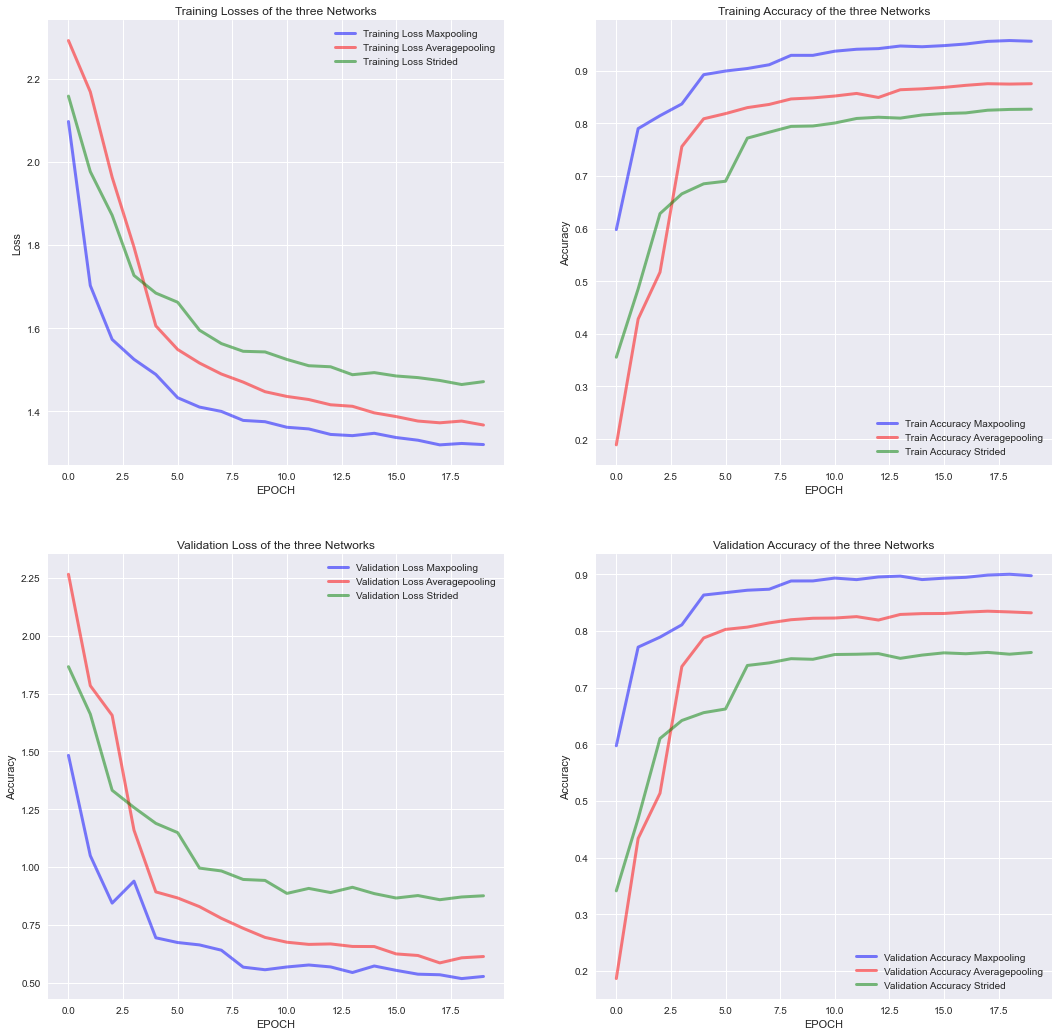

In [12]:
plt.style.use('seaborn')
fig, ax = plt.subplots(2,2)
fig.set_size_inches(18,18)

ax[0][0].plot(tl_max, c="blue", label="Training Loss Maxpooling", linewidth=3, alpha=0.5)
ax[0][0].plot(tl_avg, c="red", label="Training Loss Averagepooling", linewidth=3, alpha=0.5)
ax[0][0].plot(tl_str, c="green", label="Training Loss Strided", linewidth=3, alpha=0.5)
ax[0][0].legend(loc="best")
ax[0][0].set_xlabel("EPOCH")
ax[0][0].set_ylabel("Loss")
ax[0][0].set_title("Training Losses of the three Networks")

ax[0][1].plot(ta_max, c="blue", label="Train Accuracy Maxpooling", linewidth=3, alpha=0.5)
ax[0][1].plot(ta_avg, c="red", label="Train Accuracy Averagepooling", linewidth=3, alpha=0.5)
ax[0][1].plot(ta_str, c="green", label="Train Accuracy Strided ", linewidth=3, alpha=0.5)
ax[0][1].legend(loc="best")
ax[0][1].set_xlabel("EPOCH")
ax[0][1].set_ylabel("Accuracy")
ax[0][1].set_xscale("linear")
ax[0][1].set_yscale("linear")
ax[0][1].set_title("Training Accuracy of the three Networks")

ax[1][0].plot(vl_max, c="blue", label="Validation Loss Maxpooling", linewidth=3, alpha=0.5)
ax[1][0].plot(vl_avg, c="red", label="Validation Loss Averagepooling", linewidth=3, alpha=0.5)
ax[1][0].plot(vl_str, c="green", label="Validation Loss Strided", linewidth=3, alpha=0.5)
ax[1][0].legend(loc="best")
ax[1][0].set_xlabel("EPOCH")
ax[1][0].set_ylabel("Accuracy")
ax[1][0].set_xscale("linear")
ax[1][0].set_yscale("linear")
ax[1][0].set_title("Validation Loss of the three Networks")

ax[1][1].plot(va_max, c="blue", label="Validation Accuracy Maxpooling", linewidth=3, alpha=0.5)
ax[1][1].plot(va_avg, c="red", label="Validation Accuracy Averagepooling", linewidth=3, alpha=0.5)
ax[1][1].plot(va_str, c="green", label="Validation Accuracy Strided", linewidth=3, alpha=0.5)
ax[1][1].legend(loc="best")
ax[1][1].set_xlabel("EPOCH")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].set_xscale("linear")
ax[1][1].set_yscale("linear")
ax[1][1].set_title("Validation Accuracy of the three Networks")

We can see, that the maxpooling Network performed the best, on the validation set, as well as on the testset. That was what we were expecting, since the dataset has a few extreme features which is what maxpooling is good for. The training time for the Strided Convolution Model is a bit shorter, since it is doing the downsampling with the convolution and therefore has one layer less than the other two models. 

We also noticed, that our networks are very sensitive to random initialization. Depending on the seed, we get fluctuations of a few percent.

## 2 Compare the best of the previous CNNs with the MLP from Assignment 2, both with somewhat optimized hyper-parameters

from last assignment we have the best accuracy 0.5178 with hyperparamters, num_neurons: (512, 256, 128), lr: 0.001, optimizer: RMSprop. We will compare this with cnn with averagepooling

In [13]:
cnn_model = CNNClassifier(ds_method="Maxpooling").to(device)
optimizer_cnn = torch.optim.RMSprop(cnn_model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [14]:
tl_cnn, ta_cnn, vl_cnn, va_cnn = training(cnn_model, optimizer_cnn, SVHN_trainloader, SVHN_validationloader, 20)

Model:  CNNClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ds_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplac

100%|██████████| 79/79 [00:06<00:00, 12.26it/s]


Epoch 1
Epoch Train Loss: 3.5433622307247585, Epoch Train Accuracy: 0.4598169191919192
Epoch Validation Loss: 1.8938027725944035, Epoch Validation Accuracy: 0.45569620253164556 



100%|██████████| 79/79 [00:06<00:00, 12.67it/s]


Epoch 2
Epoch Train Loss: 1.8593970684090046, Epoch Train Accuracy: 0.7063604797979798
Epoch Validation Loss: 1.2824185996115962, Epoch Validation Accuracy: 0.696993670886076 



100%|██████████| 79/79 [00:06<00:00, 12.97it/s]


Epoch 3
Epoch Train Loss: 1.6115844435162014, Epoch Train Accuracy: 0.8246212121212121
Epoch Validation Loss: 0.9144943492322029, Epoch Validation Accuracy: 0.8069620253164557 



100%|██████████| 79/79 [00:06<00:00, 13.15it/s]


Epoch 4
Epoch Train Loss: 1.4945167033359257, Epoch Train Accuracy: 0.7520675505050505
Epoch Validation Loss: 1.2758335222171833, Epoch Validation Accuracy: 0.7287381329113924 



100%|██████████| 79/79 [00:05<00:00, 13.23it/s]


Epoch 5
Epoch Train Loss: 1.4556056306819722, Epoch Train Accuracy: 0.88510101010101
Epoch Validation Loss: 0.6709470028364206, Epoch Validation Accuracy: 0.8571004746835443 



100%|██████████| 79/79 [00:06<00:00, 13.03it/s]


Epoch 6
Epoch Train Loss: 1.4267610728138624, Epoch Train Accuracy: 0.9023516414141414
Epoch Validation Loss: 0.6621635601490359, Epoch Validation Accuracy: 0.8693631329113924 



100%|██████████| 79/79 [00:05<00:00, 13.18it/s]


Epoch 7
Epoch Train Loss: 1.4108805646800031, Epoch Train Accuracy: 0.8898832070707071
Epoch Validation Loss: 0.7151611288891563, Epoch Validation Accuracy: 0.858682753164557 



100%|██████████| 79/79 [00:05<00:00, 13.40it/s]


Epoch 8
Epoch Train Loss: 1.3932235187954374, Epoch Train Accuracy: 0.927667297979798
Epoch Validation Loss: 0.5928766474693636, Epoch Validation Accuracy: 0.8920094936708861 



100%|██████████| 79/79 [00:06<00:00, 12.90it/s]


Epoch 9
Epoch Train Loss: 1.3690306137306523, Epoch Train Accuracy: 0.9252209595959596
Epoch Validation Loss: 0.6316123800941661, Epoch Validation Accuracy: 0.8873615506329114 



100%|██████████| 79/79 [00:05<00:00, 13.50it/s]


Epoch 10
Epoch Train Loss: 1.3714799454717925, Epoch Train Accuracy: 0.9127525252525253
Epoch Validation Loss: 0.6273737138585199, Epoch Validation Accuracy: 0.875 



100%|██████████| 79/79 [00:05<00:00, 13.61it/s]


Epoch 11
Epoch Train Loss: 1.3614308443936434, Epoch Train Accuracy: 0.9383522727272727
Epoch Validation Loss: 0.5522125046464461, Epoch Validation Accuracy: 0.8927017405063291 



100%|██████████| 79/79 [00:05<00:00, 13.38it/s]


Epoch 12
Epoch Train Loss: 1.343477560895862, Epoch Train Accuracy: 0.9303030303030303
Epoch Validation Loss: 0.5572268630884871, Epoch Validation Accuracy: 0.8830102848101266 



100%|██████████| 79/79 [00:06<00:00, 13.02it/s]


Epoch 13
Epoch Train Loss: 1.3447901287464181, Epoch Train Accuracy: 0.8994949494949495
Epoch Validation Loss: 0.6655750119987922, Epoch Validation Accuracy: 0.8589794303797469 



100%|██████████| 79/79 [00:05<00:00, 15.48it/s]


Epoch 14
Epoch Train Loss: 1.3403282878374811, Epoch Train Accuracy: 0.9257102272727272
Epoch Validation Loss: 0.5939988648589654, Epoch Validation Accuracy: 0.8778678797468354 



100%|██████████| 79/79 [00:04<00:00, 16.13it/s]


Epoch 15
Epoch Train Loss: 1.3346869531303944, Epoch Train Accuracy: 0.8220012626262626
Epoch Validation Loss: 0.9141830417174327, Epoch Validation Accuracy: 0.7864912974683544 



100%|██████████| 79/79 [00:04<00:00, 16.03it/s]


Epoch 16
Epoch Train Loss: 1.3319585725514576, Epoch Train Accuracy: 0.9556818181818182
Epoch Validation Loss: 0.4940354864619955, Epoch Validation Accuracy: 0.9023931962025317 



100%|██████████| 79/79 [00:05<00:00, 15.79it/s]


Epoch 17
Epoch Train Loss: 1.3246668541070186, Epoch Train Accuracy: 0.9544665404040404
Epoch Validation Loss: 0.5180689337887342, Epoch Validation Accuracy: 0.9035799050632911 



100%|██████████| 79/79 [00:04<00:00, 16.08it/s]


Epoch 18
Epoch Train Loss: 1.3197474590455642, Epoch Train Accuracy: 0.9593907828282828
Epoch Validation Loss: 0.517788548635531, Epoch Validation Accuracy: 0.9048655063291139 



100%|██████████| 79/79 [00:04<00:00, 16.18it/s]


Epoch 19
Epoch Train Loss: 1.3245085646407773, Epoch Train Accuracy: 0.9570549242424242
Epoch Validation Loss: 0.5062268674373627, Epoch Validation Accuracy: 0.9005142405063291 



100%|██████████| 79/79 [00:05<00:00, 15.29it/s]

Epoch 20
Epoch Train Loss: 1.3130789065601849, Epoch Train Accuracy: 0.9547190656565656
Epoch Validation Loss: 0.5226814614821084, Epoch Validation Accuracy: 0.8963607594936709 



In [15]:
import torch.nn.functional as F

class LinearClassifier(torch.nn.Module):

    def __init__(self, num_neurons=(50,20), activation=F.relu, init=None):
        super(LinearClassifier, self).__init__()
        self.in_features = 3*32**2
        self.out_features = 10

        self.neurons = (self.in_features,) + num_neurons + (self.out_features,)
        self.layers = list(zip(self.neurons,self.neurons[1::]))

        self.flatten  = torch.nn.Flatten(1,-1)

        self.layers = torch.nn.ModuleList(
            [torch.nn.Linear(in_layer, out_layer) for in_layer, out_layer in self.layers]
        )

        self.activation = activation


    def forward(self, x) -> list:
        x = self.activation(self.layers[0](self.flatten(x))) #flatten tensor
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)  

linear_model = LinearClassifier((512,256,128)).to(device)
optimizer_linear = torch.optim.RMSprop(linear_model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [16]:
tl_linear, ta_linear, vl_linear, va_linear = training(linear_model, optimizer_linear, SVHN_trainloader, SVHN_validationloader, 20, save=False)

Model:  LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


100%|██████████| 79/79 [00:04<00:00, 16.08it/s]


Epoch 1
Epoch Train Loss: 1.4421981123962788, Epoch Train Accuracy: 0.5519097222222222
Epoch Validation Loss: 1.4729331384731243, Epoch Validation Accuracy: 0.5444026898734177 



100%|██████████| 79/79 [00:04<00:00, 15.81it/s]


Epoch 2
Epoch Train Loss: 0.8910364171471259, Epoch Train Accuracy: 0.6752840909090909
Epoch Validation Loss: 1.0874933411803427, Epoch Validation Accuracy: 0.6541732594936709 



100%|██████████| 79/79 [00:05<00:00, 15.41it/s]


Epoch 3
Epoch Train Loss: 0.7558648817466967, Epoch Train Accuracy: 0.7320233585858585
Epoch Validation Loss: 0.9911666504944427, Epoch Validation Accuracy: 0.6982792721518988 



100%|██████████| 79/79 [00:04<00:00, 15.87it/s]


Epoch 4
Epoch Train Loss: 0.6706338816218906, Epoch Train Accuracy: 0.7391098484848485
Epoch Validation Loss: 0.9479089899908139, Epoch Validation Accuracy: 0.7026305379746836 



100%|██████████| 79/79 [00:04<00:00, 16.12it/s]


Epoch 5
Epoch Train Loss: 0.6066859543925583, Epoch Train Accuracy: 0.7935606060606061
Epoch Validation Loss: 0.8170418407343611, Epoch Validation Accuracy: 0.7474287974683544 



100%|██████████| 79/79 [00:05<00:00, 15.70it/s]


Epoch 6
Epoch Train Loss: 0.5615391005169261, Epoch Train Accuracy: 0.827477904040404
Epoch Validation Loss: 0.6920036628276487, Epoch Validation Accuracy: 0.7750197784810127 



100%|██████████| 79/79 [00:04<00:00, 16.05it/s]


Epoch 7
Epoch Train Loss: 0.5230439763478558, Epoch Train Accuracy: 0.8098169191919192
Epoch Validation Loss: 0.8150790616681304, Epoch Validation Accuracy: 0.7631526898734177 



100%|██████████| 79/79 [00:05<00:00, 15.76it/s]


Epoch 8
Epoch Train Loss: 0.4887264034663788, Epoch Train Accuracy: 0.8004734848484848
Epoch Validation Loss: 0.84211392606361, Epoch Validation Accuracy: 0.7454509493670886 



100%|██████████| 79/79 [00:04<00:00, 16.17it/s]


Epoch 9
Epoch Train Loss: 0.4602397658307143, Epoch Train Accuracy: 0.8181818181818182
Epoch Validation Loss: 0.8326257105115094, Epoch Validation Accuracy: 0.753065664556962 



100%|██████████| 79/79 [00:05<00:00, 15.45it/s]


Epoch 10
Epoch Train Loss: 0.4372398683820108, Epoch Train Accuracy: 0.8678661616161616
Epoch Validation Loss: 0.6993913771230963, Epoch Validation Accuracy: 0.7960838607594937 



100%|██████████| 79/79 [00:05<00:00, 15.74it/s]


Epoch 11
Epoch Train Loss: 0.4070305705371529, Epoch Train Accuracy: 0.7385574494949495
Epoch Validation Loss: 1.4380722136437138, Epoch Validation Accuracy: 0.6799841772151899 



100%|██████████| 79/79 [00:04<00:00, 15.92it/s]


Epoch 12
Epoch Train Loss: 0.3940114903931666, Epoch Train Accuracy: 0.8715119949494949
Epoch Validation Loss: 0.7275334038311922, Epoch Validation Accuracy: 0.7950949367088608 



100%|██████████| 79/79 [00:05<00:00, 15.06it/s]


Epoch 13
Epoch Train Loss: 0.37283409261944317, Epoch Train Accuracy: 0.8785353535353535
Epoch Validation Loss: 0.7233924616741229, Epoch Validation Accuracy: 0.7996439873417721 



100%|██████████| 79/79 [00:05<00:00, 15.40it/s]


Epoch 14
Epoch Train Loss: 0.3562743231353134, Epoch Train Accuracy: 0.8250631313131314
Epoch Validation Loss: 0.9222022377991979, Epoch Validation Accuracy: 0.7481210443037974 



100%|██████████| 79/79 [00:04<00:00, 15.82it/s]


Epoch 15
Epoch Train Loss: 0.3427997348886548, Epoch Train Accuracy: 0.8177556818181818
Epoch Validation Loss: 0.9684049434299711, Epoch Validation Accuracy: 0.7439675632911392 



100%|██████████| 79/79 [00:04<00:00, 15.84it/s]


Epoch 16
Epoch Train Loss: 0.3290280325846239, Epoch Train Accuracy: 0.8441287878787879
Epoch Validation Loss: 0.9472724870790409, Epoch Validation Accuracy: 0.764932753164557 



100%|██████████| 79/79 [00:04<00:00, 16.00it/s]


Epoch 17
Epoch Train Loss: 0.31295213227470714, Epoch Train Accuracy: 0.9130997474747474
Epoch Validation Loss: 0.7124982068810282, Epoch Validation Accuracy: 0.8174446202531646 



100%|██████████| 79/79 [00:04<00:00, 16.09it/s]


Epoch 18
Epoch Train Loss: 0.30142077836725445, Epoch Train Accuracy: 0.8872159090909091
Epoch Validation Loss: 0.8329644101329997, Epoch Validation Accuracy: 0.7981606012658228 



100%|██████████| 79/79 [00:04<00:00, 16.29it/s]


Epoch 19
Epoch Train Loss: 0.28894888451605133, Epoch Train Accuracy: 0.890719696969697
Epoch Validation Loss: 0.8046153966761842, Epoch Validation Accuracy: 0.7960838607594937 



100%|██████████| 79/79 [00:04<00:00, 16.05it/s]

Epoch 20
Epoch Train Loss: 0.28372801439930695, Epoch Train Accuracy: 0.8870738636363636
Epoch Validation Loss: 0.8069370173955266, Epoch Validation Accuracy: 0.7958860759493671 



Text(0.5, 1.0, 'Accuracy of the CNN and Linear Network')

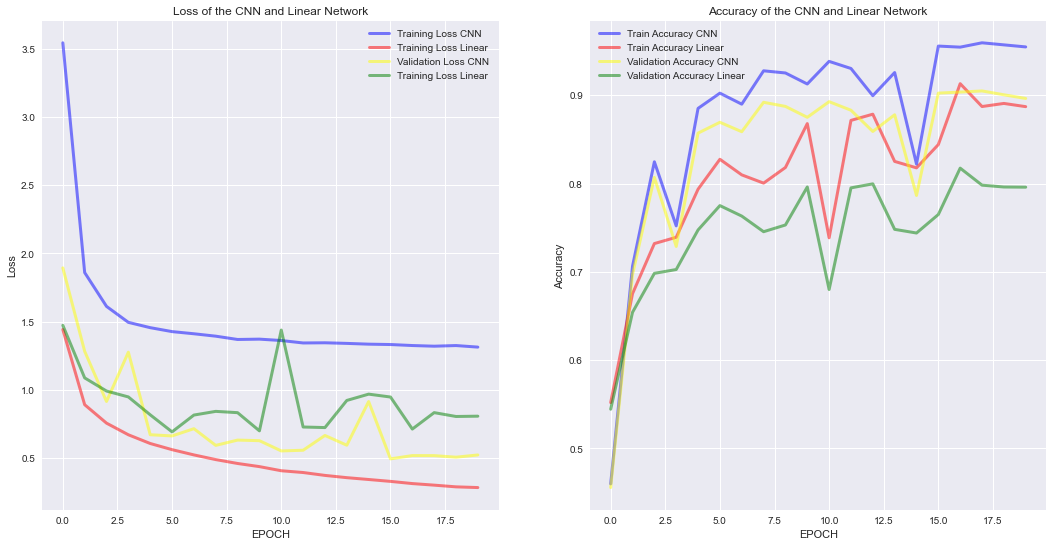

In [17]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,9)

ax[0].plot(tl_cnn, c="blue", label="Training Loss CNN", linewidth=3, alpha=0.5)
ax[0].plot(tl_linear, c="red", label="Training Loss Linear", linewidth=3, alpha=0.5)
ax[0].plot(vl_cnn, c="yellow", label="Validation Loss CNN", linewidth=3, alpha=0.5)
ax[0].plot(vl_linear, c="green", label="Training Loss Linear", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("EPOCH")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss of the CNN and Linear Network")

ax[1].plot(ta_cnn, c="blue", label="Train Accuracy CNN", linewidth=3, alpha=0.5)
ax[1].plot(ta_linear, c="red", label="Train Accuracy Linear", linewidth=3, alpha=0.5)
ax[1].plot(va_cnn, c="yellow", label="Validation Accuracy CNN", linewidth=3, alpha=0.5)
ax[1].plot(va_linear, c="green", label="Validation Accuracy Linear", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("EPOCH")
ax[1].set_ylabel("Accuracy")
ax[1].set_xscale("linear")
ax[1].set_yscale("linear")
ax[1].set_title("Accuracy of the CNN and Linear Network")

We can see, that the CNN Model outperforms the Linear Model on the SVHN Dataset. But the difference is not as big as we had thought. Maybe this is because the SVHN Dataset is not very different from MNIST and therefore still quite easy for a linear Model. But you can observer, that the Linear Model is overfitting like in the previous assignment. This could be explained by the amount of parameters, that is quite high with a linear model, so the model just learns the dataset by heart.

## 3 Visualize several convolutional kernels and activations

In [18]:
cnn_model = load_model(cnn_model, optimizer_cnn)

torch.Size([64, 3, 3, 3])
torch.Size([128, 64, 3, 3])
torch.Size([256, 128, 3, 3])
torch.Size([512, 256, 3, 3])
torch.Size([512, 512, 3, 3])


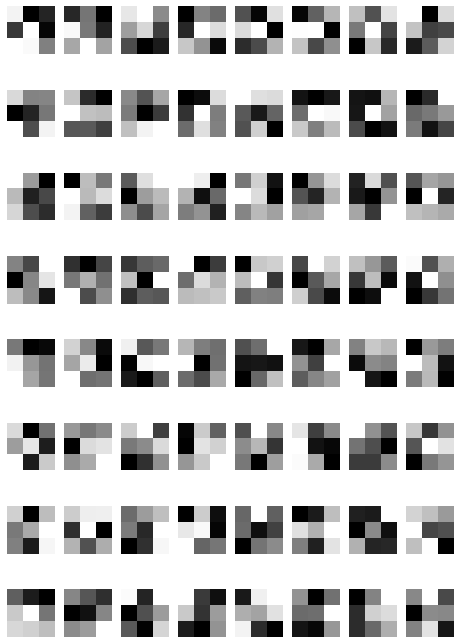

In [19]:
conv_kernel = []
for layer in cnn_model.modules():
    if isinstance(layer, nn.Conv2d):
        print((layer.weight).shape)
        c = layer.weight.to("cpu")
        c = c.permute((3, 2, 1, 0))
        conv_kernel.append(c)
        
fig1 = plt.figure(figsize=(8, 12))
for i in range(1, 65):
    f = conv_kernel[0][:, :, :, i-1].detach().numpy()
    fig1 = plt.subplot(8, 8, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='gray') 
plt.show()  
            

#### These are some visualizations for the activation functions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


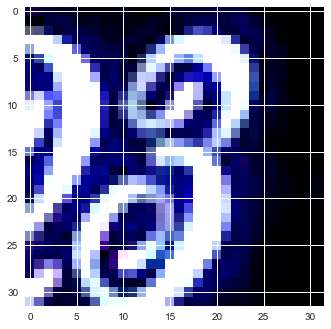

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.402     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(SVHN_trainloader)
image, labels = dataiter.next()

test_image = image[0]

imshow(torchvision.utils.make_grid(test_image))

In [21]:
class SaveOutput:
    def __init__(self):
        self.outputs = []
        self.activations = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []

save_output = SaveOutput()

hook_handles = []

for layer in cnn_model.modules():
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)

test_image = test_image.unsqueeze(0).to(device)
out = cnn_model(test_image)
test_image.shape

torch.Size([1, 3, 32, 32])

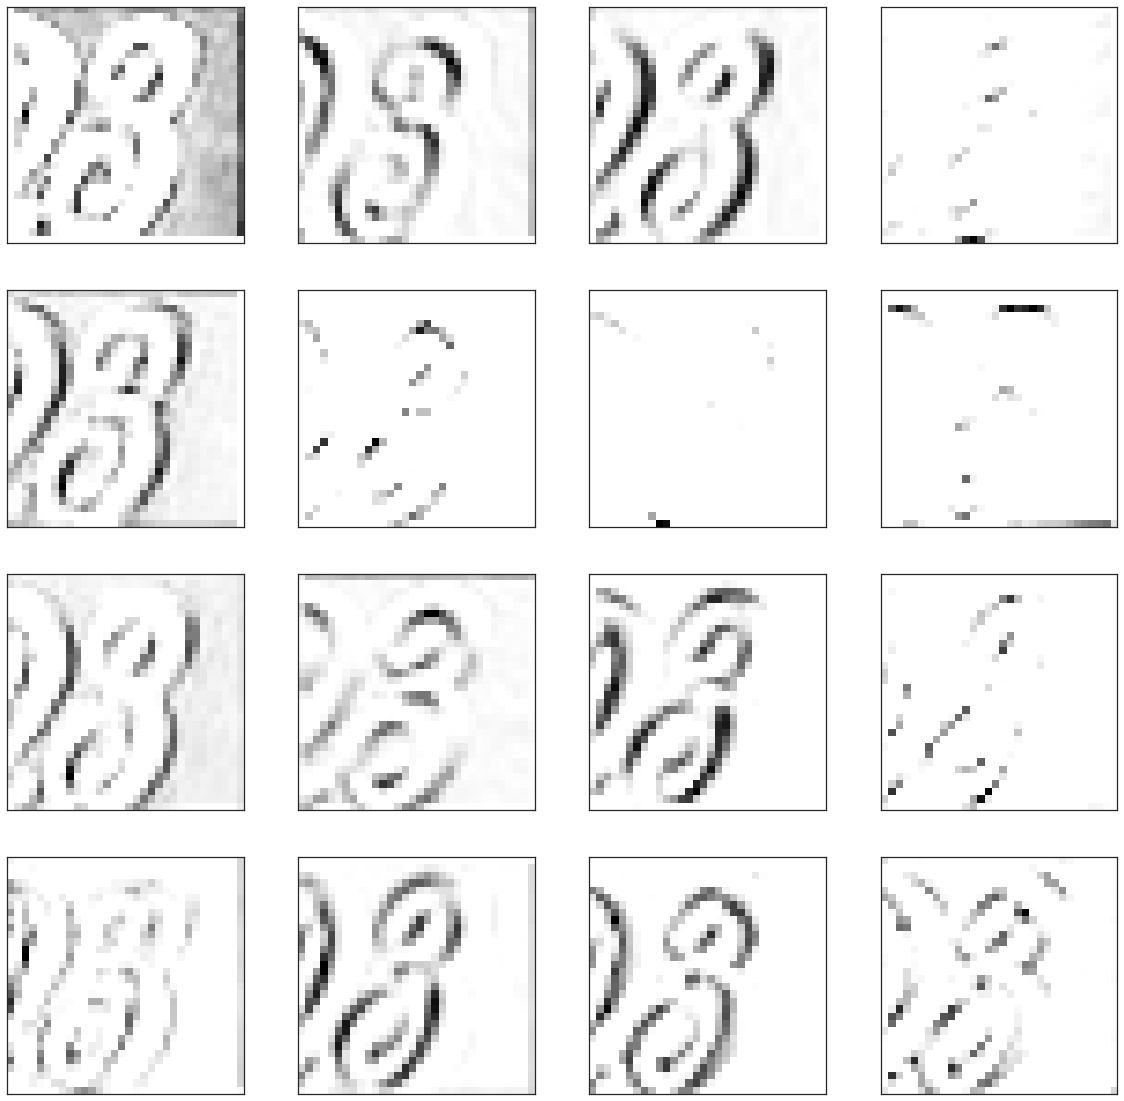

In [35]:
import matplotlib.pyplot as plt

def module_output_to_numpy(tensor):
    return tensor.detach().to('cpu').numpy()    

images = module_output_to_numpy(save_output.outputs[0])

with plt.style.context("seaborn-white"):
    plt.figure(figsize=(20, 20), frameon=False)
    
    for idx in range(16):
        plt.subplot(4, 4, idx+1)
        plt.imshow(images[0, idx])
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

As we can see the different kernels visualized above, produce very different activations of the image. We can also see, that some of the activations barely show anything of the image.

## 4 train a model using dropout and one without dropout. 

In [23]:
model_d = CNNClassifier(ds_method="Maxpooling", ).to(device)
optimizer_d = torch.optim.Adam(model_d.parameters(), lr=0.001)

In [24]:
model_without_d = CNNClassifier(ds_method="Maxpooling", dropout=False).to(device)
optimizer_without_d = torch.optim.Adam(model_without_d.parameters(), lr=0.001)

In [25]:
%%time
tl_d, _, _, va_d = training(model_d, optimizer_d, SVHN_trainloader, SVHN_validationloader, 20)

Model:  CNNClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ds_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplac

100%|██████████| 79/79 [00:04<00:00, 15.86it/s]


Epoch 1
Epoch Train Loss: 2.08368734133364, Epoch Train Accuracy: 0.5571496212121212
Epoch Validation Loss: 1.4668741301645207, Epoch Validation Accuracy: 0.5629944620253164 



100%|██████████| 79/79 [00:04<00:00, 15.81it/s]


Epoch 2
Epoch Train Loss: 1.7645526450089735, Epoch Train Accuracy: 0.6675662878787879
Epoch Validation Loss: 1.176810617688336, Epoch Validation Accuracy: 0.6653481012658228 



100%|██████████| 79/79 [00:04<00:00, 16.02it/s]


Epoch 3
Epoch Train Loss: 1.6816395345360342, Epoch Train Accuracy: 0.6901041666666666
Epoch Validation Loss: 1.0302563143681875, Epoch Validation Accuracy: 0.6865110759493671 



100%|██████████| 79/79 [00:05<00:00, 15.78it/s]


Epoch 4
Epoch Train Loss: 1.642355921051719, Epoch Train Accuracy: 0.7031723484848484
Epoch Validation Loss: 0.9427087269251859, Epoch Validation Accuracy: 0.6956091772151899 



100%|██████████| 79/79 [00:05<00:00, 15.58it/s]


Epoch 5
Epoch Train Loss: 1.6157330958530156, Epoch Train Accuracy: 0.7351483585858586
Epoch Validation Loss: 0.9671912208388124, Epoch Validation Accuracy: 0.7202333860759493 



100%|██████████| 79/79 [00:04<00:00, 15.94it/s]


Epoch 6
Epoch Train Loss: 1.5692337898292927, Epoch Train Accuracy: 0.7624053030303031
Epoch Validation Loss: 0.8218625580208211, Epoch Validation Accuracy: 0.7470332278481012 



100%|██████████| 79/79 [00:09<00:00,  8.43it/s]


Epoch 7
Epoch Train Loss: 1.546269290374987, Epoch Train Accuracy: 0.7671717171717172
Epoch Validation Loss: 0.8136665964428382, Epoch Validation Accuracy: 0.7513844936708861 



100%|██████████| 79/79 [00:05<00:00, 14.25it/s]


Epoch 8
Epoch Train Loss: 1.5232157675906866, Epoch Train Accuracy: 0.771322601010101
Epoch Validation Loss: 0.79119987276536, Epoch Validation Accuracy: 0.7513844936708861 



100%|██████████| 79/79 [00:05<00:00, 15.72it/s]


Epoch 9
Epoch Train Loss: 1.5093218194113838, Epoch Train Accuracy: 0.7762468434343435
Epoch Validation Loss: 0.7824191783047929, Epoch Validation Accuracy: 0.754746835443038 



100%|██████████| 79/79 [00:05<00:00, 14.92it/s]


Epoch 10
Epoch Train Loss: 1.4922300398951829, Epoch Train Accuracy: 0.7809185606060606
Epoch Validation Loss: 0.8035368436499487, Epoch Validation Accuracy: 0.7568235759493671 



100%|██████████| 79/79 [00:05<00:00, 15.74it/s]


Epoch 11
Epoch Train Loss: 1.4904962725109525, Epoch Train Accuracy: 0.7811868686868687
Epoch Validation Loss: 0.7566905429091635, Epoch Validation Accuracy: 0.7574169303797469 



100%|██████████| 79/79 [00:05<00:00, 15.43it/s]


Epoch 12
Epoch Train Loss: 1.476458288202382, Epoch Train Accuracy: 0.7744318181818182
Epoch Validation Loss: 0.7755837780010851, Epoch Validation Accuracy: 0.7468354430379747 



100%|██████████| 79/79 [00:04<00:00, 15.82it/s]


Epoch 13
Epoch Train Loss: 1.4671916504098912, Epoch Train Accuracy: 0.7862847222222222
Epoch Validation Loss: 0.7586690798590455, Epoch Validation Accuracy: 0.7550435126582279 



100%|██████████| 79/79 [00:05<00:00, 15.51it/s]


Epoch 14
Epoch Train Loss: 1.467891647839787, Epoch Train Accuracy: 0.7877525252525253
Epoch Validation Loss: 0.7524946939341629, Epoch Validation Accuracy: 0.7583069620253164 



100%|██████████| 79/79 [00:04<00:00, 15.89it/s]


Epoch 15
Epoch Train Loss: 1.4617229119695798, Epoch Train Accuracy: 0.7900410353535353
Epoch Validation Loss: 0.7483927788613718, Epoch Validation Accuracy: 0.7574169303797469 



100%|██████████| 79/79 [00:04<00:00, 15.87it/s]


Epoch 16
Epoch Train Loss: 1.4601618839032722, Epoch Train Accuracy: 0.7952335858585858
Epoch Validation Loss: 0.7351626229437092, Epoch Validation Accuracy: 0.7595925632911392 



100%|██████████| 79/79 [00:05<00:00, 15.61it/s]


Epoch 17
Epoch Train Loss: 1.4500602267005227, Epoch Train Accuracy: 0.7936079545454545
Epoch Validation Loss: 0.7255744172047965, Epoch Validation Accuracy: 0.7603837025316456 



100%|██████████| 79/79 [00:04<00:00, 15.91it/s]


Epoch 18
Epoch Train Loss: 1.4405557704694343, Epoch Train Accuracy: 0.7969381313131313
Epoch Validation Loss: 0.7628201046321965, Epoch Validation Accuracy: 0.7603837025316456 



100%|██████████| 79/79 [00:04<00:00, 15.93it/s]


Epoch 19
Epoch Train Loss: 1.4386862232227517, Epoch Train Accuracy: 0.8002998737373738
Epoch Validation Loss: 0.7148406637620323, Epoch Validation Accuracy: 0.7621637658227848 



100%|██████████| 79/79 [00:04<00:00, 15.83it/s]

Epoch 20
Epoch Train Loss: 1.4313941955566407, Epoch Train Accuracy: 0.8010574494949495
Epoch Validation Loss: 0.7288289737852314, Epoch Validation Accuracy: 0.7619659810126582 

CPU times: total: 6min 52s
Wall time: 8min 30s


In [26]:
test_acc, test_loss, predictions_tensor, ground_truth_tensor = test(model_d, SVHN_testloader, loss_fn)
test_acc = test_acc /  len(SVHN_testloader) / 128

print("Test Accuracy using CNN with dropout: {}".format(test_acc))

100%|██████████| 204/204 [00:05<00:00, 38.82it/s]

Test Accuracy using CNN with dropout: 0.7699142156862745


In [27]:
%%time
tl_without_d, _, _, validation_without_d = training(model_without_d, optimizer_without_d, SVHN_trainloader, SVHN_validationloader, 20)

Model:  CNNClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ds_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplac

100%|██████████| 79/79 [00:05<00:00, 15.65it/s]


Epoch 1
Epoch Train Loss: 1.6130574559924578, Epoch Train Accuracy: 0.5963383838383839
Epoch Validation Loss: 1.1919201914268205, Epoch Validation Accuracy: 0.5942444620253164 



100%|██████████| 79/79 [00:05<00:00, 15.72it/s]


Epoch 2
Epoch Train Loss: 1.154036335511641, Epoch Train Accuracy: 0.6213226010101011
Epoch Validation Loss: 1.1138419999351985, Epoch Validation Accuracy: 0.6171875 



100%|██████████| 79/79 [00:05<00:00, 15.40it/s]


Epoch 3
Epoch Train Loss: 1.0398789110809865, Epoch Train Accuracy: 0.7314236111111111
Epoch Validation Loss: 0.8972479278528238, Epoch Validation Accuracy: 0.7117286392405063 



100%|██████████| 79/79 [00:04<00:00, 15.97it/s]


Epoch 4
Epoch Train Loss: 0.8465416708377876, Epoch Train Accuracy: 0.7449494949494949
Epoch Validation Loss: 0.8626219916947281, Epoch Validation Accuracy: 0.7196400316455697 



100%|██████████| 79/79 [00:05<00:00, 15.33it/s]


Epoch 5
Epoch Train Loss: 0.8040528837478522, Epoch Train Accuracy: 0.7496212121212121
Epoch Validation Loss: 0.9121605882161781, Epoch Validation Accuracy: 0.7200356012658228 



100%|██████████| 79/79 [00:05<00:00, 15.71it/s]


Epoch 6
Epoch Train Loss: 0.7788714849587642, Epoch Train Accuracy: 0.757907196969697
Epoch Validation Loss: 0.8734306376191634, Epoch Validation Accuracy: 0.7256724683544303 



100%|██████████| 79/79 [00:05<00:00, 15.58it/s]


Epoch 7
Epoch Train Loss: 0.756016959686472, Epoch Train Accuracy: 0.7546401515151515
Epoch Validation Loss: 0.8979082462153857, Epoch Validation Accuracy: 0.716376582278481 



100%|██████████| 79/79 [00:05<00:00, 15.58it/s]


Epoch 8
Epoch Train Loss: 0.7323258485456909, Epoch Train Accuracy: 0.7687973484848485
Epoch Validation Loss: 0.8913769857792915, Epoch Validation Accuracy: 0.7247824367088608 



100%|██████████| 79/79 [00:05<00:00, 15.42it/s]


Epoch 9
Epoch Train Loss: 0.7188030823914692, Epoch Train Accuracy: 0.7713383838383838
Epoch Validation Loss: 0.9061337226553808, Epoch Validation Accuracy: 0.7293314873417721 



100%|██████████| 79/79 [00:05<00:00, 15.58it/s]


Epoch 10
Epoch Train Loss: 0.7117584317019492, Epoch Train Accuracy: 0.768102904040404
Epoch Validation Loss: 0.9502546975884256, Epoch Validation Accuracy: 0.7200356012658228 



100%|██████████| 79/79 [00:04<00:00, 15.93it/s]


Epoch 11
Epoch Train Loss: 0.7052499551363666, Epoch Train Accuracy: 0.7729008838383838
Epoch Validation Loss: 0.9251361776001846, Epoch Validation Accuracy: 0.7243868670886076 



100%|██████████| 79/79 [00:05<00:00, 15.42it/s]


Epoch 12
Epoch Train Loss: 0.7003651020352286, Epoch Train Accuracy: 0.7743055555555556
Epoch Validation Loss: 0.9590287887597386, Epoch Validation Accuracy: 0.7268591772151899 



100%|██████████| 79/79 [00:05<00:00, 15.75it/s]


Epoch 13
Epoch Train Loss: 0.696861968136797, Epoch Train Accuracy: 0.7729324494949495
Epoch Validation Loss: 0.954162554650367, Epoch Validation Accuracy: 0.7208267405063291 



100%|██████████| 79/79 [00:05<00:00, 15.47it/s]


Epoch 14
Epoch Train Loss: 0.6972511606987076, Epoch Train Accuracy: 0.7756786616161616
Epoch Validation Loss: 0.9711111365239832, Epoch Validation Accuracy: 0.7259691455696202 



100%|██████████| 79/79 [00:05<00:00, 14.85it/s]


Epoch 15
Epoch Train Loss: 0.6838603536890011, Epoch Train Accuracy: 0.7767361111111111
Epoch Validation Loss: 0.9852650316455697, Epoch Validation Accuracy: 0.7237935126582279 



100%|██████████| 79/79 [00:04<00:00, 16.00it/s]


Epoch 16
Epoch Train Loss: 0.6859482288962663, Epoch Train Accuracy: 0.7734848484848484
Epoch Validation Loss: 1.0152644145337841, Epoch Validation Accuracy: 0.7215189873417721 



100%|██████████| 79/79 [00:04<00:00, 15.95it/s]


Epoch 17
Epoch Train Loss: 0.6927677708442765, Epoch Train Accuracy: 0.772427398989899
Epoch Validation Loss: 0.9673414517052566, Epoch Validation Accuracy: 0.7231012658227848 



100%|██████████| 79/79 [00:05<00:00, 15.71it/s]


Epoch 18
Epoch Train Loss: 0.6858582895813566, Epoch Train Accuracy: 0.7758996212121212
Epoch Validation Loss: 1.0182344521148294, Epoch Validation Accuracy: 0.7224090189873418 



100%|██████████| 79/79 [00:05<00:00, 15.09it/s]


Epoch 19
Epoch Train Loss: 0.6786503537736758, Epoch Train Accuracy: 0.7781407828282828
Epoch Validation Loss: 1.0255657630630686, Epoch Validation Accuracy: 0.7263647151898734 



100%|██████████| 79/79 [00:04<00:00, 15.83it/s]

Epoch 20
Epoch Train Loss: 0.6826065662533346, Epoch Train Accuracy: 0.7777304292929293
Epoch Validation Loss: 1.0167994982079616, Epoch Validation Accuracy: 0.7255735759493671 

CPU times: total: 6min 53s
Wall time: 8min 26s


In [28]:
test_acc, test_loss, predictions_tensor, ground_truth_tensor = test(model_without_d, SVHN_testloader, loss_fn)
test_acc = test_acc /  len(SVHN_testloader) / 128

print("Test Accuracy using CNN without dropout: {}".format(test_acc))

100%|██████████| 204/204 [00:05<00:00, 39.41it/s]

Test Accuracy using CNN without dropout: 0.7374004289215687


Text(0.5, 1.0, 'Validation Accuracy Dropout vs no Dropout')

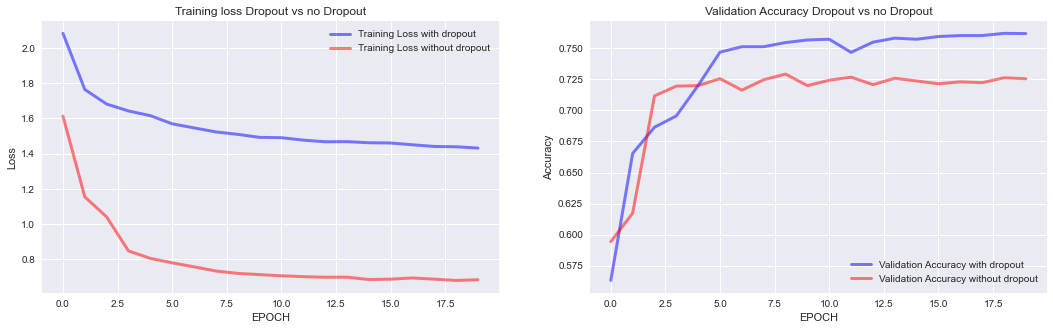

In [29]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18,5)

ax[0].plot(tl_d, c="blue", label="Training Loss with dropout", linewidth=3, alpha=0.5)
ax[0].plot(tl_without_d, c="red", label="Training Loss without dropout", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("EPOCH")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training loss Dropout vs no Dropout")

ax[1].plot(va_d, c="blue", label="Validation Accuracy with dropout", linewidth=3, alpha=0.5)
ax[1].plot(validation_without_d, c="red", label="Validation Accuracy without dropout", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("EPOCH")
ax[1].set_ylabel("Accuracy")
ax[1].set_xscale("linear")
ax[1].set_yscale("linear")
ax[1].set_title("Validation Accuracy Dropout vs no Dropout")

As we can seen above, cnn without dropout took more time to train, which make sense, because the network had to calculate each neurons.
The loss decrased faster and more in the training without dropout. This is because dropout intends to avoid overfitting, the loss with it won't drop that fast since we will "deactivated" some neurons. The validation accuracy with dropout outperformed the one without dropout.

##### Extrapoint: Implement your own version of early stopping

In [30]:
#This is a kinda dirty implementation. Ideally we would do this with a wrapper, but i would have to rewrite the training function entirely to 
#make it work

def early_stopping(model,optimizer, epoch, best_accuracy,episodes_passed, validation_accuracy, max_episodes=5):

    stop = False

    if validation_accuracy >= best_accuracy:
        best_accuracy = validation_accuracy
        episodes_passed = 0
        if(not os.path.exists("models")):
            os.makedirs("models")
    

        savepath = f"models/model_early_stopped.pth"
        
        torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, savepath)
    else:
        episodes_passed += 1

    if episodes_passed >= max_episodes:
        stop = True


    return best_accuracy, episodes_passed, stop

In [31]:
def training(model, optimizer, trainloader, validationloader, epochs, save=True):
    print("Model: ", model)
    train_loss_list = []
    train_accuracy_list = []
    validation_loss_list = []
    validation_accuracy_list = []

    best_accuracy = 0
    episodes_passed = 0

    for epoch in range(epochs):
        train_loss = train(model, trainloader , optimizer, loss_fn)
        train_accuracy, _, _, _ = test(model, trainloader, loss_fn) 
        train_accuracy = train_accuracy / len(trainloader) / BSZ
        validation_accuracy, validation_loss, _, _ = test(model, validationloader, loss_fn) 
        validation_accuracy = validation_accuracy / len(validationloader) / BSZ

        best_accuracy, episodes_passed, stop = early_stopping(model, optimizer, epoch, best_accuracy, episodes_passed, validation_accuracy)
        if stop:
            print("Stopped after epoch: {}, with accuracy: {}. the model can be loaded from: {}".format(epoch + 1, best_accuracy ,"model_early_stopped.pth"))
            break

        print("Epoch", epoch + 1)
        print("Epoch Train Loss: {}, Epoch Train Accuracy: {}".format(train_loss, train_accuracy))
        print("Epoch Validation Loss: {}, Epoch Validation Accuracy: {} \n".format(validation_loss, validation_accuracy))
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        validation_loss_list.append(validation_loss)
        validation_accuracy_list.append(validation_accuracy)
        #num_gradient_list.append(num_gradient.item())
        
                
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    if(not os.path.exists("traingtracks")):
        os.makedirs("traingtracks")
    
    if save:
        savepath = f"models/model_{model.ds_method}.pth"
        
        torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, savepath)
    
    return train_loss_list, train_accuracy_list, validation_loss_list, validation_accuracy_list, epoch

In [32]:
model_d_early = CNNClassifier(ds_method="Maxpooling").to(device)
optimizer_d_early = torch.optim.Adam(model_d_early.parameters(), lr=0.001)

In [33]:
%%time
tl_d, vl_d, ta_d, va_d, epoch = training(model_d_early, optimizer_d_early, SVHN_trainloader, SVHN_validationloader, 50)

Model:  CNNClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ds_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplac

100%|██████████| 79/79 [00:05<00:00, 15.77it/s]


Epoch 1
Epoch Train Loss: 2.0695806255244245, Epoch Train Accuracy: 0.6335385101010101
Epoch Validation Loss: 1.3739052678965316, Epoch Validation Accuracy: 0.6359770569620253 



100%|██████████| 79/79 [00:04<00:00, 15.92it/s]


Epoch 2
Epoch Train Loss: 1.6654134829839071, Epoch Train Accuracy: 0.810842803030303
Epoch Validation Loss: 0.7845639888244339, Epoch Validation Accuracy: 0.8004351265822784 



100%|██████████| 79/79 [00:05<00:00, 15.72it/s]


Epoch 3
Epoch Train Loss: 1.506898740806965, Epoch Train Accuracy: 0.8320707070707071
Epoch Validation Loss: 0.8247222598594955, Epoch Validation Accuracy: 0.8168512658227848 



100%|██████████| 79/79 [00:05<00:00, 15.75it/s]


Epoch 4
Epoch Train Loss: 1.434996244160816, Epoch Train Accuracy: 0.8960385101010101
Epoch Validation Loss: 0.6518172229392619, Epoch Validation Accuracy: 0.8723299050632911 



100%|██████████| 79/79 [00:05<00:00, 13.22it/s]


Epoch 5
Epoch Train Loss: 1.3866121359545776, Epoch Train Accuracy: 0.8997001262626263
Epoch Validation Loss: 0.5658892434609087, Epoch Validation Accuracy: 0.8709454113924051 



100%|██████████| 79/79 [00:04<00:00, 16.06it/s]


Epoch 6
Epoch Train Loss: 1.3617149345802537, Epoch Train Accuracy: 0.9119791666666667
Epoch Validation Loss: 0.564091613021078, Epoch Validation Accuracy: 0.8829113924050633 



100%|██████████| 79/79 [00:05<00:00, 15.78it/s]


Epoch 7
Epoch Train Loss: 1.3385818637982763, Epoch Train Accuracy: 0.920864898989899
Epoch Validation Loss: 0.5045442618901217, Epoch Validation Accuracy: 0.8891416139240507 



100%|██████████| 79/79 [00:04<00:00, 15.97it/s]


Epoch 8
Epoch Train Loss: 1.3363144972107628, Epoch Train Accuracy: 0.9275410353535354
Epoch Validation Loss: 0.5002151935160914, Epoch Validation Accuracy: 0.8910205696202531 



100%|██████████| 79/79 [00:05<00:00, 15.21it/s]


Epoch 9
Epoch Train Loss: 1.3102909213364726, Epoch Train Accuracy: 0.934832702020202
Epoch Validation Loss: 0.487800051894369, Epoch Validation Accuracy: 0.8958662974683544 



100%|██████████| 79/79 [00:04<00:00, 15.95it/s]


Epoch 10
Epoch Train Loss: 1.3035676617815037, Epoch Train Accuracy: 0.9359690656565657
Epoch Validation Loss: 0.4858629065978376, Epoch Validation Accuracy: 0.8946795886075949 



100%|██████████| 79/79 [00:05<00:00, 15.54it/s]


Epoch 11
Epoch Train Loss: 1.3018002754510052, Epoch Train Accuracy: 0.9405618686868686
Epoch Validation Loss: 0.45163152451756633, Epoch Validation Accuracy: 0.8957674050632911 



100%|██████████| 79/79 [00:04<00:00, 15.82it/s]


Epoch 12
Epoch Train Loss: 1.3062156266636318, Epoch Train Accuracy: 0.9437184343434344
Epoch Validation Loss: 0.44859596822835224, Epoch Validation Accuracy: 0.8975474683544303 



100%|██████████| 79/79 [00:04<00:00, 15.95it/s]


Epoch 13
Epoch Train Loss: 1.2896308584646745, Epoch Train Accuracy: 0.9494476010101011
Epoch Validation Loss: 0.4326901428307159, Epoch Validation Accuracy: 0.9036787974683544 



100%|██████████| 79/79 [00:05<00:00, 15.73it/s]


Epoch 14
Epoch Train Loss: 1.2679572280007179, Epoch Train Accuracy: 0.9464804292929293
Epoch Validation Loss: 0.4410825473598287, Epoch Validation Accuracy: 0.8988330696202531 



100%|██████████| 79/79 [00:04<00:00, 15.89it/s]


Epoch 15
Epoch Train Loss: 1.2678731616097267, Epoch Train Accuracy: 0.9472853535353535
Epoch Validation Loss: 0.4236355423927307, Epoch Validation Accuracy: 0.8996242088607594 



100%|██████████| 79/79 [00:05<00:00, 15.52it/s]


Epoch 16
Epoch Train Loss: 1.2684538752141625, Epoch Train Accuracy: 0.9535037878787879
Epoch Validation Loss: 0.42479440154908576, Epoch Validation Accuracy: 0.9019976265822784 



100%|██████████| 79/79 [00:05<00:00, 15.72it/s]


Epoch 17
Epoch Train Loss: 1.2635470778051048, Epoch Train Accuracy: 0.9518939393939394
Epoch Validation Loss: 0.4285782400188567, Epoch Validation Accuracy: 0.8945806962025317 



100%|██████████| 79/79 [00:05<00:00, 15.67it/s]

Stopped after epoch: 18, with accuracy: 0.9036787974683544. the model can be loaded from: model_early_stopped.pth
CPU times: total: 6min 9s
Wall time: 7min 33s


Depending on the initial weights, the early stopping function stopps the network between 15 and 20 epochs.